In [1]:
import osqp
import cvxpy as cp
import numpy as np

import scipy as sp
from scipy import sparse

import matplotlib.pyplot as plt
from scipy.linalg import hankel

import gym
import mujoco_py
from gym import wrappers
from IPython import display
plt.rcParams["figure.figsize"] = (18,6)
%matplotlib inline

## Data Collection

In [2]:
env = gym.make('InvertedPendulum-v4', render_mode='rgb_array')
"""
    Timestep for InvertedPendelum-v4 is 0.02
"""
obs, info = env.reset()
# ud = np.array([0])
# yd = obs
# done = False
# start = True

Tini = 1
n = 4
N = 15
m = 1
p = 4
T = (m+1)*(Tini + N + n) + 300
print(T)
render_collection = False

ud = []
yd = []

for i in range(T):
    
    action = [obs[1]*3 - np.random.randn()*0.2]
    obs, rew, done, info, _ = env.step(action)
    ud = np.append(ud,action)
    yd = np.append(yd,obs)

    if render_collection:
        plt.title(f"Action {action[0]:.2f} Theta {obs[1]:.2f} Iter {i}")
        plt.imshow(env.render())
        display.display(plt.gcf())    
        display.clear_output(wait=True)

    if np.abs(obs[1]) > 0.05 or np.abs(obs[0]) > 0.1 or np.abs(obs[2]) > 0.1 or np.abs(obs[3]) > 0.1 :
        print('reset')
        obs, info = env.reset()
        i = 0

env.close()
print(f'yd shape : {yd.shape}   ud shape : {ud.shape}')

326
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset


/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


In [3]:
L = Tini + N + n
H = hankel(ud[0:L], ud[L-1:])
rank = np.linalg.matrix_rank(H)
print(f'H has rank {rank} and shape {H.shape}')
if rank != H.shape[0]:
    raise ValueError

H has rank 13 and shape (13, 314)


In [4]:
L = Tini + N

U = hankel(ud[0:L], ud[L-1:])

Y = np.zeros((L*p, T-L+1))
for i in range(0,T-L+1):
    Y[:,i] = yd[p*i:p*(L+i)]

Up = U[0:Tini, :]
Uf = U[Tini:, :]
print(f'U = {U.shape}, Up = {Up.shape}, Uf = {Uf.shape}')

Yp = Y[0:p*Tini, :]
Yf = Y[p*Tini:, :]
print(f'Y = {Y.shape}, Yp = {Yp.shape}, Yf = {Yf.shape}')

# u_ini = ud[:Tini]
# y_ini = yd[:p*Tini]
u_ini = np.kron(np.ones(Tini), np.array([0]))
y_ini = np.kron(np.ones(Tini), np.array([0,0,0,0]))
# u_ini = [0, *ud[:Tini-1]]
# y_ini = [np.zeros(p), *yd[:p*(Tini-1)]]
print(f'u ini : {u_ini}\ny ini : {y_ini}')


U = (9, 318), Up = (1, 318), Uf = (8, 318)
Y = (36, 318), Yp = (4, 318), Yf = (32, 318)
u ini : [0.]
y ini : [0. 0. 0. 0.]


## Solver

In [5]:
u_ini = np.kron(np.ones(Tini), np.array([0]))
y_ini = np.kron(np.ones(Tini), np.array([0,0,0,0]))
g = cp.Variable(T - Tini - N + 1)
u = cp.Variable(N)
y = cp.Variable(N*p)
PI = np.vstack([Up, Yp, Uf])
PI = np.linalg.pinv(PI)@PI
# print(PI.shape)
I = np.eye(PI.shape[0])
PI = I - PI
# print(PI.shape)
sig_y = cp.Variable(p*Tini)
y_r = np.array([0,0,0,0]).reshape((p,))
# y_r = np.zeros(p).reshape((p,))
A = np.vstack([Up,Yp,Uf,Yf])
A = np.linalg.pinv(A)
u_r = 0 # steady state control input
stacked_ref = np.hstack([
  np.kron(np.ones(Tini).reshape((Tini,)), u_r),
  np.kron(np.ones(Tini).reshape((Tini,)), y_r),
  np.kron(np.ones(N).reshape((N,)), u_r),
  np.kron(np.ones(N).reshape((N,)), y_r)
])

g_r = A @ stacked_ref
r = np.kron(np.ones(N-1).reshape((N-1,)), y_r)
Q = np.diag([1,100,1,1])*5
# Q = np.eye(p)
Q_block = np.kron(np.eye(N-1), Q)
R = np.eye(N)

cost = cp.quad_form(y[-p:] - y_r, 10*Q) + cp.quad_form(y[:-p] - r, Q_block) + cp.quad_form(u,R) + cp.sum_squares(PI@(g))*10000 + cp.norm(g, 1)*1000 
# cost += cp.norm1(sig_y)*100000

env = gym.make('InvertedPendulum-v4', render_mode='rgb_array')
# env._max_episode_steps = 50
obs = env.reset()
yT = [*y_ini]
uT = [*u_ini]
done = False
iter = 0
render_solution = False
y_const = np.kron(np.ones(N), np.array([0.15, 0.07, 0.15, 0.15]))
u_const = np.ones(N)*3

while iter <= 20:

  constraints = [
    Up @ g == u_ini,
    Yp @ g == y_ini, 
    Uf @ g == u,
    Yf @ g == y,
    cp.abs(u) <= u_const,
    cp.abs(y) <= y_const
  ]

  prob = cp.Problem(cp.Minimize(cost), constraints)
  prob.solve(solver=cp.OSQP, verbose=False)
  # print(prob.variables()[1].value)
  action = prob.variables()[1].value[0]
  # print(prob._constraints)

  obs,_,done,_,_ = env.step([action])
  # obs = obs + np.random.uniform(low=-0.01, high=0.01, size=(p,))
  yT = np.append(yT, obs)
  uT = np.append(uT, action)
  
  if render_solution:
    plt.title(f"Action {action:.2f}, X {obs[0]:.2f}, Theta {obs[1]:.2f} Iter {iter}")
    plt.imshow(env.render())
    display.display(plt.gcf())    
    display.clear_output(wait=True)

  u_ini = uT[-Tini:]
  y_ini = yT[-p*Tini:]
  iter += 1

In [6]:
iter

21

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


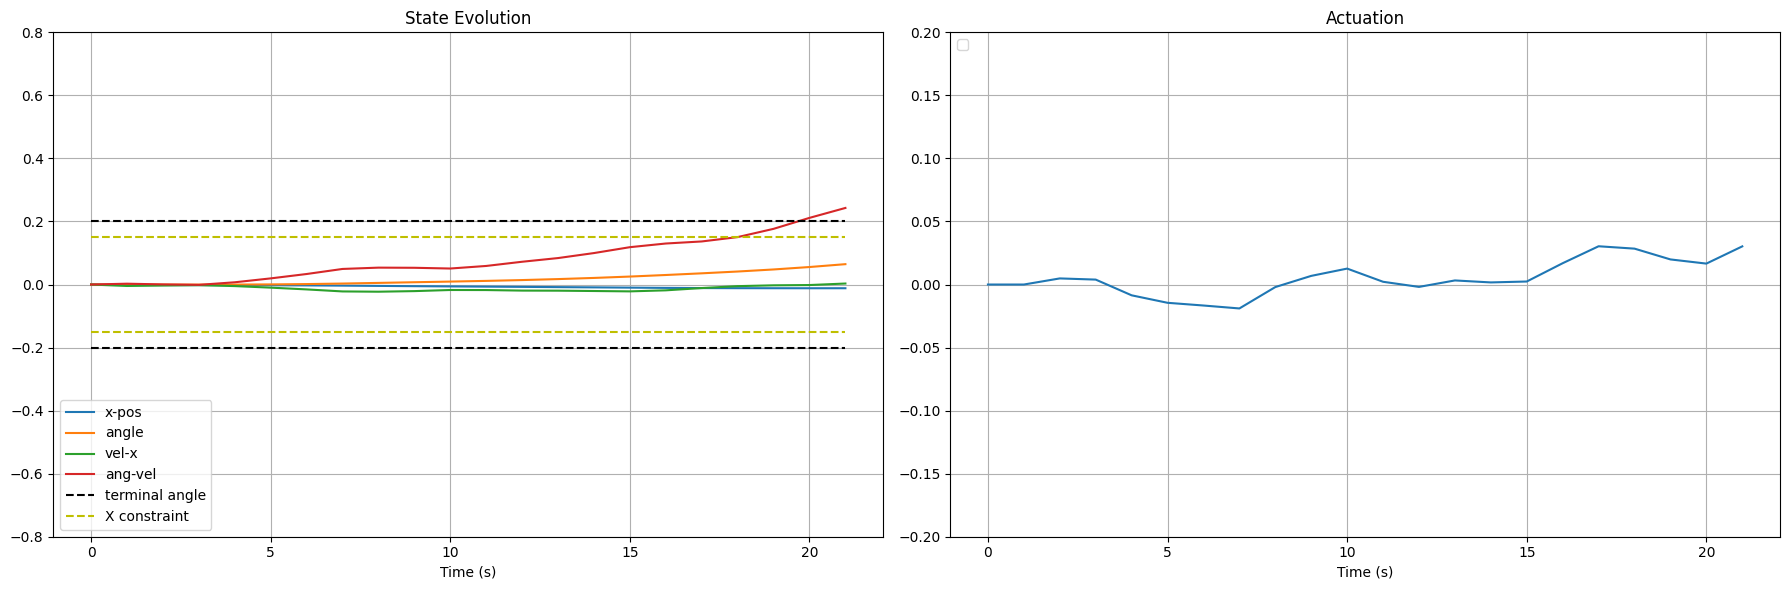

In [7]:
T = len(uT)
yT = yT.reshape((T,4))

plt.subplot(1,2,1)
plt.plot(range(0,T), yT, label=['x-pos', 'angle', 'vel-x', 'ang-vel'])
plt.plot(range(0,T), np.ones(T)*0.2, 'k--',label='terminal angle')
plt.plot(range(0,T), -np.ones(T)*0.2, 'k--')
plt.plot(range(0,T), np.ones(T)*0.15, 'y--', label='X constraint')
plt.plot(range(0,T), -np.ones(T)*0.15, 'y--')
plt.legend(loc="lower left")
plt.ylim((-0.8,0.8))
plt.xlabel('Time (s)')
plt.title("State Evolution")
plt.grid('on')
plt.tight_layout()

plt.subplot(1,2,2)
plt.plot(range(0,T), uT)
plt.legend(loc="upper left")
plt.xlabel('Time (s)')
plt.title("Actuation")
plt.ylim((-0.2,0.2))
plt.grid('on')
plt.tight_layout()

plt.show()
yT = yT.reshape((T*p,))
